# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from joblib import dump, load

# [1]. Reading Data

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect(r'/home/pranay/ML datasource/amazon-fine-food-reviews/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


# [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

## Note : We are training on 20k points

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True, kind='quicksort',na_position='last')
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html

In [6]:
# Deduplicate a data
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first', inplace=False)
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
final.shape

(19354, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
# remove wrong helpfulnessNumerator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(19354, 10)

In [10]:
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

1    16339
0     3015
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [14]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar

def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [15]:
preprocessed_reviews = filterised_text(final['Text'].values)
# preprocessed_reviews[1822]

100%|██████████| 19354/19354 [00:09<00:00, 2141.98it/s]


## [3.2] Preprocess Summary

In [16]:
preprocessed_summary = filterised_text(final['Summary'].values)
# preprocessed_summary[1822]

100%|██████████| 19354/19354 [00:04<00:00, 3906.89it/s]


In [17]:
bow_trained_model_5000 ='/home/pranay/ML trained models/BoW/bow_trained_model_5000'
bow_trained_model_20000 ='/home/pranay/ML trained models/BoW/bow_trained_model_20000'
bow_trained_model_75000 ='/home/pranay/ML trained models/BoW/bow_trained_model_75000'
bow_trained_count_vect ='/home/pranay/ML trained models/BoW/bow_trained_count_vect'

tf_idf_trained_model_5000 = '/home/pranay/ML trained models/TFIDF/tf_idf_trained_model_5000'
tf_idf_trained_model_20000 = '/home/pranay/ML trained models/TFIDF/tf_idf_trained_model_20000'
tf_idf_trained_model_75000 = '/home/pranay/ML trained models/TFIDF/tf_idf_trained_model_75000'
trained_tf_idf_vect_20000 = '/home/pranay/ML trained models/TFIDF/tf_idf_vect_20000'

w2v_trained_model_20000 = '/home/pranay/ML trained models/W2V/w2v_trained_model_20000'
avg_w2v_trained_model_5000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_5000'
avg_w2v_trained_model_20000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_20000'
avg_w2v_trained_model_75000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_75000'

w2v_tf_idf_trained_model_5000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_5000'
w2v_tf_idf_trained_model_20000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_20000'
w2v_tf_idf_trained_model_75000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_75000'
w2v_tf_idf_model_20000 = '/home/pranay/ML trained modelsW2V_TFIDF/w2v_tf_idf_model_20000'

tsne_trained_bow = '/home/pranay/Amazon Assignments/TSNE/bow'
tsne_trained_tfidf = '/home/pranay/Amazon Assignments/TSNE/tfidf'
tsne_trained_w2v = '/home/pranay/Amazon Assignments/TSNE/w2v'
tsne_trained_w2v_tfidf = '/home/pranay/Amazon Assignments/TSNE/w2v_tfidf'

tsne_std_bow = '/home/pranay/Amazon Assignments/TSNE/std_bow'
tsne_std_tfidf = '/home/pranay/Amazon Assignments/TSNE/std_tfidf'
tsne_std_w2v = '/home/pranay/Amazon Assignments/TSNE/std_w2v'
tsne_std_w2v_tfidf = '/home/pranay/Amazon Assignments/TSNE/std_w2v_tfidf'

# [4] Featurization

## [4.1] Bag Of Word

### CountVectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Convert a collection of text documents to a matrix of token counts

This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.

If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.



In [18]:
#BoW

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(bow_trained_model_20000)
if exists:
    print("yes exist")
    final_counts = load(bow_trained_model_20000) 
    count_vect = load(bow_trained_count_vect)
    print("the type of count vectorizer ",type(final_counts))
    print("the shape of out text BOW vectorizer ",final_counts.get_shape())
    print("the number of unique words ", final_counts.get_shape()[1])
else:   
    print("not exist")
    count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn
    count_vect.fit(preprocessed_reviews)
    print("some feature names ", count_vect.get_feature_names()[:10])
    print('='*50)

    final_counts = count_vect.transform(preprocessed_reviews)
    dump(final_counts, bow_trained_model_20000) 
    dump(count_vect, bow_trained_count_vect) 
    print("the type of count vectorizer ",type(final_counts))
    print("the shape of out text BOW vectorizer ",final_counts.get_shape())
    print("the number of unique words ", final_counts.get_shape()[1])

yes exist
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19354, 11762)
the number of unique words  11762


## [4.2] TF-IDF

### TfidfVectorizer

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Performs the TF-IDF transformation from a provided matrix of counts.
Convert a collection of raw documents to a matrix of TF-IDF features.Equivalent to CountVectorizer followed by TfidfTransformer.

In [20]:
# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(tf_idf_trained_model_20000)
if exists:
    print("yes exist")
    final_tf_idf = load(tf_idf_trained_model_20000) 
    tf_idf_vect = load(trained_tf_idf_vect_20000)
    print("the type of count vectorizer ",type(final_tf_idf))
    print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
    print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
else:   
    print("not exist")
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn
    tf_idf_vect.fit(preprocessed_reviews)
    print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
    print('='*50)
    
    final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
    dump(final_tf_idf, tf_idf_trained_model_20000) 
    dump(tf_idf_vect, trained_tf_idf_vect_20000)
    print("the type of count vectorizer ",type(final_tf_idf))
    print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
    print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

yes exist
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (19354, 11762)
the number of unique words including both unigrams and bigrams  11762


# [4.3] Word2Vec

https://www.pydoc.io/pypi/gensim-3.2.0/autoapi/models/word2vec/index.html

Produce word vectors with deep learning via word2vec’s “skip-gram and CBOW models”, using either hierarchical softmax or negative sampling

In [21]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [22]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_trained_model_20000)
if exists:
    print("exist")
    w2v_model=load(w2v_trained_model_20000)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
else:   
    print("not exist")
    if want_to_train_w2v:
        # min_count = 5 considers only words that occured atleast 5 times
        w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
        dump(w2v_model, w2v_trained_model_20000) 
        print(w2v_model.wv.most_similar('great'))
        print('='*50)
        print(w2v_model.wv.most_similar('worst'))
    
    elif want_to_use_google_w2v and is_your_ram_gt_16g:
        if os.path.isfile('GoogleNews-vectors-negative300.bin'):
            w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
            print(w2v_model.wv.most_similar('great'))
            print(w2v_model.wv.most_similar('worst'))
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


exist
[('awesome', 0.8309022188186646), ('wonderful', 0.811127781867981), ('excellent', 0.8034428358078003), ('good', 0.8009434938430786), ('fantastic', 0.7902337312698364), ('amazing', 0.7810570597648621), ('perfect', 0.7115012407302856), ('decent', 0.6846671104431152), ('delicious', 0.6843174695968628), ('yummy', 0.6492028832435608)]
[('closest', 0.8254092931747437), ('disappointing', 0.8234403133392334), ('world', 0.7960715293884277), ('tastiest', 0.7922287583351135), ('imagined', 0.789280891418457), ('humble', 0.7876097559928894), ('surpasses', 0.7870989441871643), ('critic', 0.7839329242706299), ('diner', 0.7782721519470215), ('amongst', 0.7759752869606018)]


In [23]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8370
sample words  ['used', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product', 'available', 'traps', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully']


### [4.3.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

In [24]:
# average Word2Vec


exists = os.path.isfile(avg_w2v_trained_model_20000)
if exists:
    print("yes exist")
    sent_vectors = load(avg_w2v_trained_model_20000)
    
else:   
    print("not exist")
    
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    type(sent_vectors)
    dump(final_counts, avg_w2v_trained_model_20000) 

yes exist


#### [4.3.1.2] TFIDF weighted W2v

In [25]:
# store model to hard disk if exist then load model directly
exists = os.path.isfile(w2v_tf_idf_trained_model_20000)
if exists:
    print("yes exist")
    tfidf_sent_vectors = load(w2v_tf_idf_trained_model_20000)
    
else:   
    print("not exist")
    # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(preprocessed_reviews)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    dump(final_counts, w2v_tf_idf_trained_model_20000) 

yes exist


In [26]:
score = final['Score']
score.shape

(19354,)

# [5] Applying TSNE

In [27]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 1000)

# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 5000

### [5.1] Bag of Word in TSNE

In [31]:
from sklearn.preprocessing import StandardScaler
# Standardize data

exists = os.path.isfile(tsne_std_bow)
if exists:
    print("Yes Exist")
    bow_standardize_data = load(tsne_std_bow)
    bow_standardize_data.shape
else:
    print("not exist")
    bow_standardize_data = StandardScaler(with_mean = False).fit_transform(final_counts)
    bow_standardize_data.shape
    dump(bow_standardize_data, tsne_std_bow) 

Yes Exist


Yes Exist
(19354, 3)


/home/pranay/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


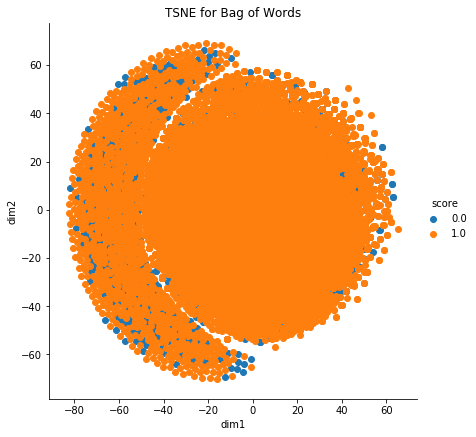

In [32]:
import seaborn as sns

exists = os.path.isfile(tsne_trained_bow)

if exists:
    print("Yes Exist")
    bow_tsne_data = load(tsne_trained_bow)
    print(bow_tsne_data.shape)
else:
    print("not exist")
    bow_tsne_data = model.fit_transform(bow_standardize_data.toarray())
    print(bow_tsne_data.shape)
    # creating a new data frame which help us in ploting the result data
    bow_tsne_data = np.vstack((bow_tsne_data.T, score)).T
    dump(bow_tsne_data, tsne_trained_bow)


tsne_df = pd.DataFrame(data=bow_tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()


#### Observation
We have took 20k points in consideration and it hard to separate data using any hyperplane, datapoints overlapped each other.

### [5.3] TF-IDF in TSNE

In [33]:
# Standardize data

exists = os.path.isfile(tsne_std_tfidf)
if exists:
    print("Yes Exist")
    tfidf_standardize_data = load(tsne_std_tfidf)
    print(tfidf_standardize_data.shape)
else:
    print("not exist")
    tfidf_standardize_data = StandardScaler(with_mean = False).fit_transform(final_tf_idf)
    print(tfidf_standardize_data.shape)
    dump(tfidf_standardize_data, tsne_std_bow)  

Yes Exist
(19354, 11762)


Yes Exist
(19354, 3)


/home/pranay/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


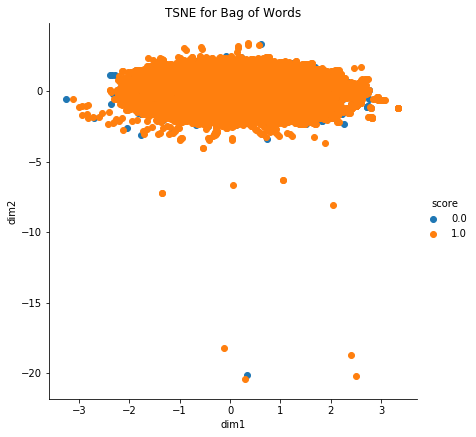

In [34]:
if exists:
    print("Yes Exist")
    tfidf_tsne_data = load(tsne_trained_tfidf)
    print(tfidf_tsne_data.shape)
else:
    print("not exist")
    tfidf_tsne_data = model.fit_transform(tfidf_standardize_data.toarray())
    print(tfidf_tsne_data.shape)
    # creating a new data frame which help us in ploting the result data
    tfidf_tsne_data = np.vstack((tfidf_tsne_data.T, score)).T
    dump(bow_tsne_data, tsne_trained_tfidf)


tsne_df = pd.DataFrame(data=tfidf_tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

#### Observation:

We have took 20k points in consideration and We can see that it is massively overlapped +ve and -ve review.

#### [5.4] Avg Word2Vect in TSNE

In [35]:
# Standardize data

exists = os.path.isfile(tsne_std_w2v)
if exists:
    print("Yes Exist")
    w2v_standardize_data = load(tsne_std_w2v)
    print(w2v_standardize_data.shape)
else:
    print("not exist")
    w2v_standardize_data = StandardScaler(with_mean = False).fit_transform(sent_vectors)
    print(w2v_standardize_data.shape)
    dump(w2v_standardize_data, tsne_std_w2v)  

Yes Exist
(19354, 50)


Yes Exist
(19354, 3)


/home/pranay/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


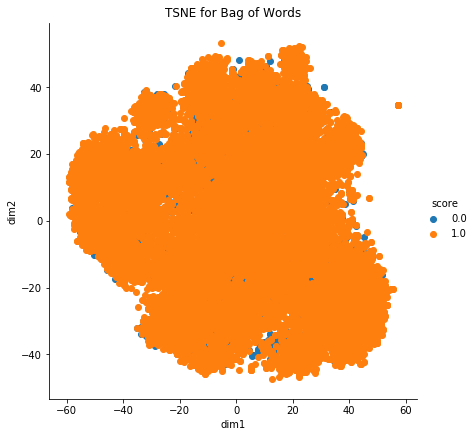

In [36]:
if exists:
    print("Yes Exist")
    w2v_tsne_data = load(tsne_trained_w2v)
    print(w2v_tsne_data.shape)
else:
    print("not exist")
    w2v_tsne_data = model.fit_transform(w2v_standardize_data.toarray())
    print(w2v_tsne_data.shape)
    # creating a new data frame which help us in ploting the result data
    tfidf_tsne_data = np.vstack((w2v_tsne_data.T, score)).T
    dump(w2v_tsne_data, tsne_trained_w2v)


tsne_df = pd.DataFrame(data=w2v_tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

#### Observation

We have took 20k points in consideration and It is hard to separate positive and negative reviews

#### [5.5] TFIDF weighted Word2Vec in TSNE

In [37]:
# Standardize data

exists = os.path.isfile(tsne_std_w2v_tfidf)
if exists:
    print("Yes Exist")
    w2v_tfidf_standardize_data = load(tsne_std_w2v_tfidf)
    print(w2v_tfidf_standardize_data.shape)
else:
    w2v_tfidf_standardize_data = StandardScaler(with_mean = False).fit_transform(tfidf_sent_vectors)
    print(w2v_tfidf_standardize_data.shape)
    dump(w2v_tfidf_standardize_data, tsne_std_w2v_tfidf)

Yes Exist
(19354, 11762)


Yes Exist
(19354, 3)


/home/pranay/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


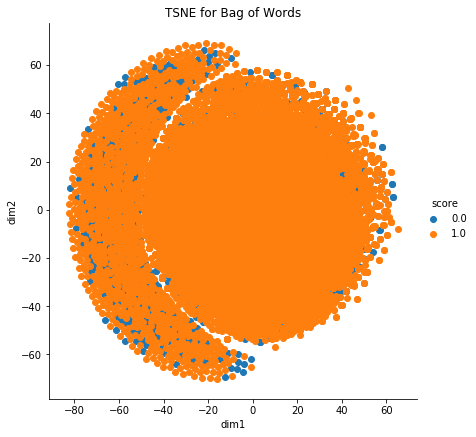

In [40]:
exists = os.path.isfile(tsne_trained_w2v_tfidf)

if exists:
    print("Yes Exist")
    w2v_tfidf_tsne_data = load(tsne_trained_w2v_tfidf)
    print(w2v_tfidf_tsne_data.shape)
else:
    print("not exist")
    w2v_tfidf_tsne_data = model.fit_transform(w2v_tfidf_standardize_data.toarray())
    print(w2v_tfidf_tsne_data.shape)
    # creating a new data frame which help us in ploting the result data
    w2v_tfidf_tsne_data = np.vstack((w2v_tfidf_tsne_data.T, score)).T
    dump(tsne_trained_w2v_tfidf, tsne_trained_w2v)


tsne_df = pd.DataFrame(data=w2v_tfidf_tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

# Conclusion:

We have took 20k points in consideration,

1. We have tried TSNE on all algorithm but none of them are separating positive and negative class.
2. we can not draw any hyperplane for above data